In [169]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.animation as animation
import sys
import sklearn
from datetime import datetime

np.set_printoptions(precision=3, suppress=True)

In [4]:
## import spreadsheet and select timeframe of interest
from datetime import timedelta
today = datetime.date(datetime.now())
d = datetime.date(datetime.now())
while d.weekday() != 6:
    d += timedelta(1)
sunday = d

dfnfl = pd.read_csv('spreadspoke_scores.csv')
dfnfl.loc[:,'gamedate'] = pd.to_datetime(dfnfl['schedule_date'])
dfnfl.loc[:,'scoredif'] = dfnfl['score_home'] - dfnfl['score_away']
dfnfltime = dfnfl[dfnfl['gamedate'] > pd.to_datetime('2002-07-31')]
dfnfltime = dfnfltime[dfnfltime['gamedate'] < pd.to_datetime('2020-7-20')]
teams = dfnfltime['team_home'].unique()
teamsid = dfnfltime['team_favorite_id'].unique()
dfnfltime

dfnflsunday = dfnfl[dfnfl['gamedate'] == pd.to_datetime(sunday)]

#create dictionary of teams and shortnames
teams_save = ['Chicago Bears', 'St. Louis Rams','Arizona Cardinals', 'Carolina Panthers',
       'Cleveland Browns', 'Dallas Cowboys', 'Jacksonville Jaguars',
       'Los Angeles Chargers', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New York Jets', 'Philadelphia Eagles',
       'Seattle Seahawks', 'Tampa Bay Buccaneers', 'New Orleans Saints',
       'Las Vegas Raiders','Oakland Raiders', 'Atlanta Falcons', 'Baltimore Ravens',
       'Cincinnati Bengals', 'Denver Broncos', 'Detroit Lions',
       'Green Bay Packers', 'Houston Texans', 'Los Angeles Rams',
       'New York Giants', 'Pittsburgh Steelers', 'Tennessee Titans',
       'Washington Redskins', 'Buffalo Bills', 'Indianapolis Colts','San Diego Chargers',
       'Kansas City Chiefs', 'San Francisco 49ers'] 

ids = ['CHI', 'STL','ARI', 'CAR', 'CLE', 'DAL', 'JAC', 'LAC', 'MIA', 'MIN', 'NE',
       'NYJ', 'PHI', 'SEA', 'TB', 'NO', 'LV','OAK', 'ATL', 'BAL', 'CIN', 'DEN',
       'DET', 'GB', 'HOU', 'LAR', 'NYG', 'PIT', 'TEN', 'WAS', 'BUF',
       'IND','SD', 'KC','SF']
teamids = {teams_save[i]: ids[i] for i in range(len(teams_save))}
#teamids = {teams[i]: teamsid[i] for i in range(len(teams))}

#split dataframe from game indexed (home and away) to each teams score and spread
dfnfltimehome = dfnfltime[['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home','team_favorite_id','spread_favorite','gamedate', 'scoredif']]
dfnfltimehome.loc[:,'team'] = dfnfltimehome['team_home']
dfnfltimehome.loc[:,'score'] = dfnfltimehome['score_home']
dfnfltimeaway = dfnfltime[['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_away', 'score_away','team_favorite_id','spread_favorite','gamedate', 'scoredif']]
dfnfltimeaway.loc[:,'team'] = dfnfltimeaway['team_away']
dfnfltimeaway.loc[:,'score'] = dfnfltimeaway['score_away']
dfnfltimeaway.loc[:,'scoredif'] = -dfnfltimeaway['scoredif']
dfnfltimesingle = pd.concat([dfnfltimehome,dfnfltimeaway])
dfnfltimesingle.drop(['score_home', 'team_home','team_away','score_away'], axis=1, inplace=True)
teamids

#calculate each teams score ATS and whether covered ATS
def spread(team,team_favorite_id,scoredif,spread_favorite,teamids):
    if teamids[team] == team_favorite_id:
        spreadscore = scoredif + spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
            
    if teamids[team] != team_favorite_id:
        spreadscore = scoredif - spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
    return spreadscore
def cover(team,team_favorite_id,scoredif,spread_favorite,teamids):
    if teamids[team] == team_favorite_id:
        spreadscore = scoredif + spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
            
    if teamids[team] != team_favorite_id:
        spreadscore = scoredif - spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
    return cover

dfnfltimesingle['spreadscore'] = dfnfltimesingle.apply(lambda row: spread(row['team'],row['team_favorite_id'],row['scoredif'],row['spread_favorite'],teamids),axis=1)
dfnfltimesingle['cover'] = dfnfltimesingle.apply(lambda row: cover(row['team'],row['team_favorite_id'],row['scoredif'],row['spread_favorite'],teamids),axis=1)

#regular season only
dfnfltimesingle = dfnfltimesingle[dfnfltimesingle['schedule_playoff']== False]
dfnfltimesingle.drop(['schedule_playoff'], axis=1, inplace=True)
dfnfltimesingle = dfnfltimesingle.reset_index()
dfnfltimesingle

### get each teams score ATS each week of the season, concat seasons vertically
years = dfnfltimesingle['schedule_season'].unique()
dfspreadall = []
dfcoverall = []
for year in years:
    print(year)
    dfnfltimesingleloop = dfnfltimesingle[dfnfltimesingle['schedule_season']==year]
    #create dataframe of score ATS for each team through the season
    dfspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingle['team'] == teams_save[0]]['spreadscore']).reset_index(drop=True)
    for team in teams_save:
        if team != teams_save[0]:
            seasonspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == team]['spreadscore']).reset_index(drop=True)
            dfspread = pd.concat([dfspread,seasonspread],axis=1)    
    dfspread.columns = teams_save
    dfspread = dfspread.transpose()
    #drop las vegas raiders because they didnt exist yet
    dfspread.dropna(inplace=True)


    #create dataframe of score ATS for each team through the season
    dfcover = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == teams_save[0]]['cover']).reset_index(drop=True)
    for team in teams_save:
        if team != teams_save[0]:
            seasoncover = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == team]['cover']).reset_index(drop=True)
            dfcover = pd.concat([dfcover,seasoncover],axis=1)    
    dfcover.columns = teams_save
    dfcover = dfcover.transpose()
    #drop las vegas raiders because they didnt exist yet
    dfcover.dropna(inplace=True)
    dfspreadall.append(dfspread)
    dfcoverall.append(dfcover)
dfspreadall = pd.concat(dfspreadall)
dfcoverall = pd.concat(dfcoverall)
dfspreadall

dfspreadall.to_excel('dfspreadall.xlsx')
dfcoverall.to_excel('dfcoverdall.xlsx')

C:\Users\hogan\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\hogan\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2002
2003


<ipython-input-4-711097ceb47b>:111: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingle['team'] == teams_save[0]]['spreadscore']).reset_index(drop=True)


2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


6160
3056
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


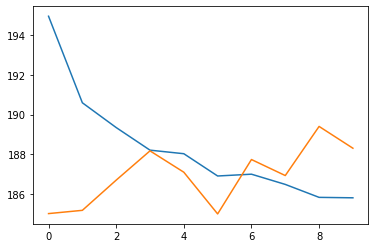

In [175]:

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
df = dfspreadall

X_train, X_test, = train_test_split(df, test_size=0.33, random_state=42)
close_train = X_train.values
close_test= X_test.values

close_train = close_train.reshape((-1,1))
close_test = close_test.reshape((-1,1))

# num_all_teams = df.shape[1]
# num_teams = 500
# close_data = df.iloc[:,0:num_teams].values
# #close_data = close_data.reshape(close_data.shape[0],1,num_teams)
# close_data = close_data.T.reshape((-1,1))
# close_data

# split_percent = 0.5
# split = int(split_percent*len(close_data))

# close_train = close_data[:split]
# close_test = close_data[split:]

date_train = X_train.reset_index().index
date_test = X_test.reset_index().index
date_total = df.reset_index().index

print(len(close_train))
print(len(close_test))


look_back = 3
batch_size = 1
train_generator = TimeseriesGenerator(close_train, close_train, length=look_back,stride=4, batch_size=batch_size)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, stride=4, batch_size=batch_size)
total_generator = TimeseriesGenerator(close_data, close_data, length=look_back, batch_size=batch_size)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(5,
#        return_sequences=True,
        activation='relu',
        input_shape=(look_back,1))
        )

# one layer SimpleRNN seems to be enough for this data set
#model.add(SimpleRNN(64, activation='relu', input_shape=(look_back, 1)))
    
# two layer model
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
# model.add(GRU(100, activation='relu'))

#model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

num_epochs = 10
history = model.fit(train_generator, validation_data=test_generator,epochs=num_epochs, verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [176]:
team = random.randint(0,len(X_test))
#team=0

# prediction = model.predict(test_generator)
# prediction = model.predict(train_generator)
# prediction = model.predict(total_generator)



close_testg = close_test[team*16:team*16+16]
close_traing = close_train[team*16:team*16+16]
graph_generator = TimeseriesGenerator(close_testg, close_testg, length=look_back,stride=1, batch_size=1)
predictiong = model.predict(graph_generator)

# close_testg = close_test[:,team]
# predictiong = prediction[:,team]

close_traing = close_traing.reshape((-1))
close_testg = close_testg.reshape((-1))
predictiong = predictiong.reshape((-1))

import plotly.graph_objects as go

trace1 = go.Scatter(
    x = date_total,
    y = close_testg,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_total+look_back,
    y = predictiong,
    #mode = 'lines',
    name = 'Prediction'
)
# trace3 = go.Scatter(
#     x = date_test,
#     y = close_testg,
#     mode='lines',
#     name = 'Ground Truth'
# )
layout = go.Layout(
    title = X_test.index[team],
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
#fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()